# Colored Multiple Shapes

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
from PIL import Image
from skimage import draw
from itertools import permutations
%matplotlib inline

## Data Generation

In [2]:
num_imgs = 60000

img_size = 32
min_object_size = 7
max_object_size = 16
num_objects = 3
num_shapes = 3
num_colors = 3

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, 3)) + 1
shapes = np.zeros((num_imgs, num_objects), dtype = int)
shape_labels = ['rectangle', 'circle', 'triangle']
colors = np.zeros((num_imgs, num_objects), dtype = int)
color_labels = ['r', 'g', 'b']

for i_img in range(num_imgs):
    
    for i_object in range(num_objects):
        shape = np.random.randint(num_shapes)
        shapes[i_img, i_object] = shape
        color = np.random.randint(num_colors)
        colors[i_img, i_object] = color
        rgb = np.zeros(3)
        
        # TODO: Introduce some variation to the colors by adding a small random offset to the rgb values.
        offset = np.random.uniform(0, 0.8)
        if color == 0:
            rgb = (1., 0 + offset, 0 + offset)
        elif color == 1:
            rgb = (0 + offset, 1., 0 + offset)
        else:
            rgb = (0 + offset, 0 + offset, 1.)
            
        if shape == 0: # rectangle
            w, h = np.random.randint(min_object_size, max_object_size, size = 2)
            x = np.random.randint(0, img_size - w)
            y = np.random.randint(0, img_size - h)
            imgs[i_img, x:x + w, y:y + h] = rgb
            bboxes[i_img, i_object] = [x, y, w, h]
            
        elif shape == 1: # circle
            r = 0.5 * np.random.randint(min_object_size, max_object_size)
            x = np.random.randint(r, img_size - r)
            y = np.random.randint(r, img_size - r)
            bboxes[i_img, i_object] = [x - r, y - r, 2 * r, 2 * r]
            r, c = draw.circle(x, y, radius = r)
            imgs[i_img, r, c] = rgb
            
        else: # triangle
            size = np.random.randint(min_object_size, max_object_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = rgb
            bboxes[i_img, i_object] = [x, y, size, size]
            
imgs = imgs * 255
imgs = imgs.astype(np.uint8)

imgs.shape, bboxes.shape, shapes.shape, colors.shape

((60000, 32, 32, 3), (60000, 3, 4), (60000, 3), (60000, 3))

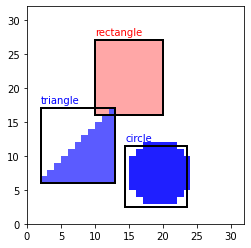

In [60]:
i = np.random.randint(num_imgs)
plt.imshow(np.transpose(imgs[i], (1, 0, 2)), interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox, shape, color in zip(bboxes[i], shapes[i], colors[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'k', fc = 'none'))
    plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color = color_labels[color], clip_on = False)

## Preprocessing

In [61]:
X = (imgs - 128.) / 255.
X.shape, np.mean(X), np.std(X)

((60000, 32, 32, 3), 0.40127888761233527, 0.23963712159965453)

In [62]:
colors_onehot = np.zeros((num_imgs, num_objects, num_colors))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        colors_onehot[i_img, i_object, colors[i_img, i_object]] = 1

shapes_onehot = np.zeros((num_imgs, num_objects, num_shapes))
for i_img in range(num_imgs):
    for i_object in range(num_objects):
        shapes_onehot[i_img, i_object, shapes[i_img, i_object]] = 1
        
y = np.concatenate([bboxes / img_size, shapes_onehot, colors_onehot], axis = -1).reshape(num_imgs, -1)
y.shape, np.all(np.argmax(colors_onehot, axis = -1) == colors)

((60000, 30), True)

## Train Test Split

In [63]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## CNN Model

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten

model = Sequential([
        Convolution2D(32, kernel_size = (6, 6), 
                      strides = (2, 2),
                      input_shape = (32, 32, 3),
                      padding = 'same', activation = 'relu'), 
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Convolution2D(64, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Convolution2D(128, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        Convolution2D(256, kernel_size = (3, 3), 
                      strides = (1, 1), 
                      padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (3, 3), strides = (2, 2), padding = 'same'),
        Flatten(),
        Dropout(0.4),
        Dense(256, activation = 'relu'),
        Dropout(0.4),
        Dense(y.shape[-1])
    ])

model.compile('adamax', 'mse')
model.summary()
# adam, adamax, nadam, adagrad

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 32)        3488      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)        

## IoU Calculating Function

In [66]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [67]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [68]:
num_epochs = 40
iou_max = 0.
fact = math.factorial(num_objects)

flipped_train_y = np.array(train_y)
flipped = np.zeros((len(train_y), num_epochs))
ious_epochs = np.zeros((len(train_y), num_epochs))
dists_epochs = np.zeros((len(train_y), num_epochs))
mses_epochs = np.zeros((len(train_y), num_epochs))
acc_shapes_epoch = np.zeros((len(train_y), num_epochs))
acc_colors_epoch = np.zeros((len(train_y), num_epochs))

# TODO: Calculate ious directly for all samples (using slices of the array pred_y for x, y, w, h).
for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        pred = pred_bboxes.reshape(num_objects, -1)
        exp = exp_bboxes.reshape(num_objects, -1)
        p_exp = list(permutations(exp))
        
        # ignore the shape value
        pred_bboxes = pred[:, :4]
        exp_bboxes = exp[:, :4]
        
        p_exp_bboxes = list(permutations(exp_bboxes))
        ious = np.zeros((fact, num_objects))
        dists = np.zeros((fact, num_objects))
        mses = np.zeros((fact, num_objects))
        p_ious = np.zeros(fact)
        p_mses = np.zeros(fact)
        p_dists = np.zeros(fact)
        
        for j, exp_bboxes in enumerate(p_exp_bboxes):
            exp_bboxes = list(exp_bboxes) 
            for k in range(num_objects):
                ious[j, k] = IOU(exp_bboxes[k], pred_bboxes[k])
                dists[j, k] = distance(exp_bboxes[k], pred_bboxes[k])
                mses[j, k] = np.mean(np.square(exp_bboxes[k] - pred_bboxes[k]))
            p_ious[j] = sum(ious[j, :])
            p_dists[j] = sum(dists[j, :])
            p_mses[j] = sum(mses[j, :])
            
        keymax = p_mses.argmin()
        ious_epochs[i, epoch] += p_ious[keymax] / num_objects
        dists_epochs[i, epoch] += p_dists[keymax] / num_objects
        mses_epochs[i, epoch] += p_mses[keymax] / num_objects
        
        flipped_train_y[i] = np.array(p_exp[keymax]).flatten()
        if keymax != 0:
            flipped[i, epoch] = 1.
        
        if p_ious[keymax] > iou_max:
            model.save('Colored_Multiple_Shapes_model.h5')
            iou_max = p_ious[keymax]
        
        acc_shapes_epoch[i, epoch] = np.mean(np.argmax(pred[:, 4:4 + num_shapes], axis = -1) == np.argmax(exp[:, 4:4 + num_shapes], axis = -1))
        acc_colors_epoch[i, epoch] = np.mean(np.argmax(pred[:, 4 + num_shapes:4 + num_shapes + num_colors], axis = -1) == np.argmax(exp[:, 4 + num_shapes:4 + num_shapes + num_colors], axis = -1))    
            
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epochs[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epochs[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epochs[:, epoch])))
    print('Accuracy shapes: {}'.format(np.mean(acc_shapes_epoch[:, epoch])))
    print('Accuracy colors: {}'.format(np.mean(acc_colors_epoch[:, epoch])))

Epoch 0
1500/1500 [==============================] - 30s 20ms/step - loss: 0.1276 - val_loss: 0.1153
Flipped 82.66666666666667 % of all elements
Mean IOU: 0.23058025071392957
Mean dist: 0.21457565326635086
Mean mse: 0.017329829231718528
Accuracy shapes: 0.4890486111111111
Accuracy colors: 0.5998680555555556
Epoch 1
1500/1500 [==============================] - 27s 18ms/step - loss: 0.1084 - val_loss: 0.1197
Flipped 36.96666666666666 % of all elements
Mean IOU: 0.2966671048249239
Mean dist: 0.17436140250770552
Mean mse: 0.012712819098619267
Accuracy shapes: 0.6004791666666666
Accuracy colors: 0.7603124999999998
Epoch 2
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0899 - val_loss: 0.1269
Flipped 17.297916666666666 % of all elements
Mean IOU: 0.3216232869396835
Mean dist: 0.16304402962165793
Mean mse: 0.011573743224905503
Accuracy shapes: 0.6889652777777777
Accuracy colors: 0.8208472222222222
Epoch 3
1500/1500 [==============================] - 28s 19ms/step - loss:

1500/1500 [==============================] - 29s 19ms/step - loss: 0.0364 - val_loss: 0.1569
Flipped 4.829166666666667 % of all elements
Mean IOU: 0.42484735259776085
Mean dist: 0.12006215296437064
Mean mse: 0.007805576683242387
Accuracy shapes: 0.928361111111111
Accuracy colors: 0.9555972222222222
Epoch 28
1500/1500 [==============================] - 29s 19ms/step - loss: 0.0360 - val_loss: 0.1583
Flipped 4.160416666666666 % of all elements
Mean IOU: 0.4262955405649327
Mean dist: 0.11941490081097231
Mean mse: 0.007762799828951434
Accuracy shapes: 0.9295138888888889
Accuracy colors: 0.9594444444444445
Epoch 29
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0350 - val_loss: 0.1589
Flipped 4.68125 % of all elements
Mean IOU: 0.4238131012867172
Mean dist: 0.12057160947564619
Mean mse: 0.007837837130189314
Accuracy shapes: 0.9294444444444445
Accuracy colors: 0.9561041666666665
Epoch 30
1500/1500 [==============================] - 27s 18ms/step - loss: 0.0349 - val_los

## Model Layers

weights.shape: (32, 6, 6, 3)
0.0004704142 0.07262626 -0.18783432 0.14475101
127.6574074074074 18.512339246826013 80 164


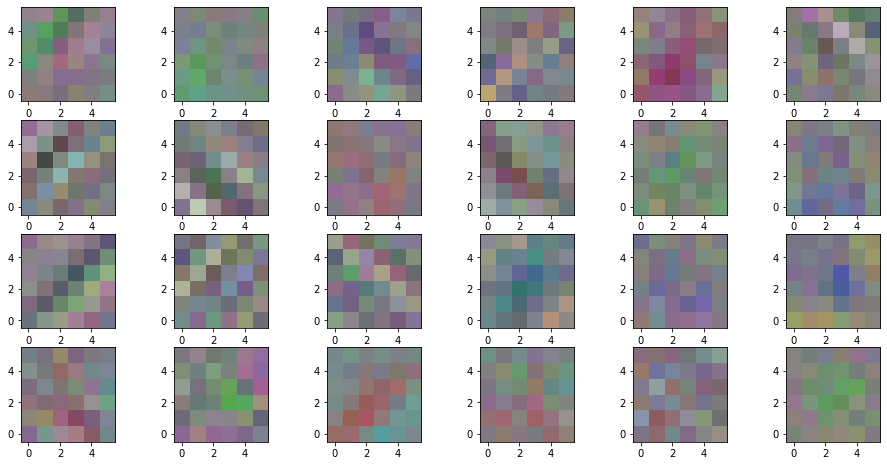

In [69]:
weights = model.layers[0].get_weights()[0]
weights = weights.transpose(3, 0, 1, 2)
print('weights.shape:', weights.shape)
print(np.mean(weights[0]), np.std(weights[0]), np.min(weights[0]), np.max(weights[0]))
adj_weights = (weights * 255.) + 128.
adj_weights = adj_weights.astype(np.uint8)
print(np.mean(adj_weights[0]), np.std(adj_weights[0]), np.min(adj_weights[0]), np.max(adj_weights[0]))
plt.figure(figsize = (16, 8))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(adj_weights[i, :, :], interpolation = 'none', origin = 'lower', cmap = 'Greys')

## Flipping Track

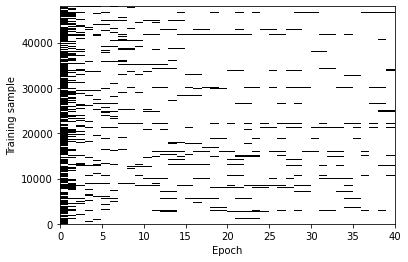

In [70]:
plt.pcolormesh(flipped[:, :], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('colored_multiple_shapes_flips.png', dpi = 100)
plt.show()

## Metrics Track

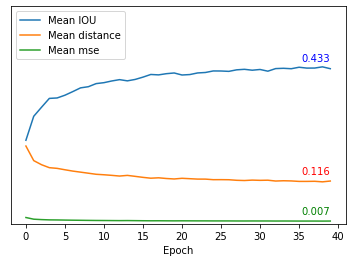

In [71]:
mean_ious_epoch = np.mean(ious_epochs, axis = 0)
mean_dists_epoch = np.mean(dists_epochs, axis = 0)
mean_mses_epoch = np.mean(mses_epochs, axis = 0)
plt.plot(mean_ious_epoch, label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label = 'Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label = 'Mean mse')  # relative to image size
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')

plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.ylim(0, 0.6)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
plt.savefig('training_metrics.png', dpi = 100)

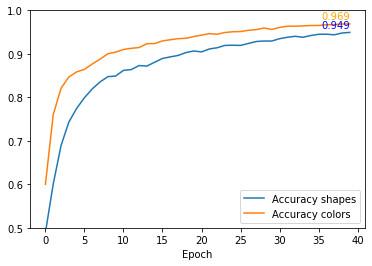

In [72]:
mean_acc_shapes_epoch = np.mean(acc_shapes_epoch, axis = 0)
mean_acc_colors_epoch = np.mean(acc_colors_epoch, axis = 0)
plt.plot(mean_acc_shapes_epoch, label = 'Accuracy shapes')  # between predicted and assigned true bboxes
plt.plot(mean_acc_colors_epoch, label = 'Accuracy colors')
plt.annotate(np.round(np.max(mean_acc_shapes_epoch), 3), (len(mean_acc_shapes_epoch) - 1, mean_acc_shapes_epoch[-1] + 0.01), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.max(mean_acc_colors_epoch), 3), (len(mean_acc_colors_epoch) - 1, mean_acc_colors_epoch[-1] + 0.01), horizontalalignment = 'right', color = 'orange')

plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.ylim(0.5, 1)

plt.savefig('training_metrics_classification.png', dpi = 100)

## Denormalize Data

In [73]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = np.argmax(pred_y[..., 4:4 + num_shapes], axis = -1).astype(int)  # take max from probabilities
pred_colors = np.argmax(pred_y[..., 4 + num_shapes:4 + num_shapes + num_colors], axis = -1).astype(int)
pred_bboxes.shape, pred_shapes.shape, pred_colors.shape

((12000, 3, 4), (12000, 3), (12000, 3))

## Visualize Results

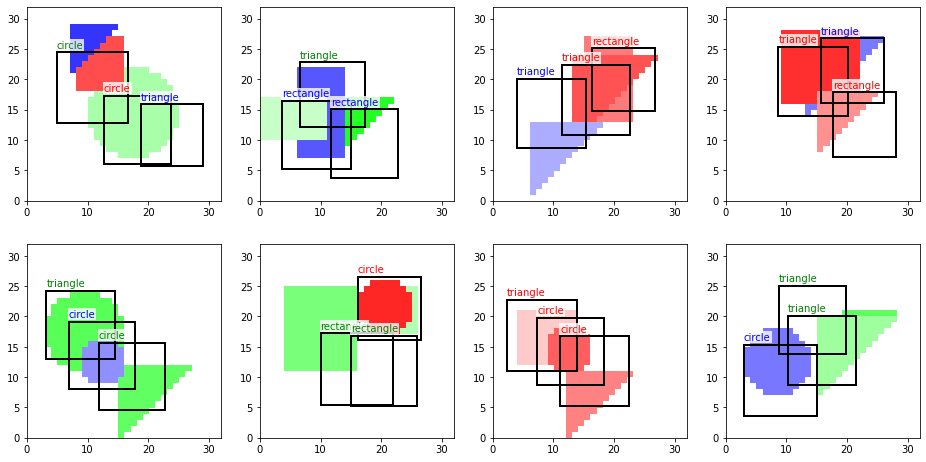

In [74]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 9):
    plt.subplot(2, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i], interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for bbox, shape, color in zip(pred_bboxes[i], pred_shapes[i], pred_colors[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'k', fc = 'none'))
        plt.annotate(shape_labels[shape], (bbox[0], bbox[1] + bbox[3] + 0.7), color = color_labels[color], clip_on = False, bbox = {'fc': 'w', 'ec': 'none', 'pad': 1, 'alpha': 0.8})

In [75]:
np.mean(pred_bboxes[:, :, 2]), np.std(pred_bboxes[:, :, 2])

(11.029729, 0.5048759)

## Overall Assessment

In [98]:
from keras.models import load_model
fact = math.factorial(num_objects)
model_test = load_model('Colored_Multiple_Shapes_model.h5')
pred_y = model_test.predict(test_X)
sum_iou = 0.
sum_dist = 0.
sum_mse = 0.
flipped_test_y = np.array(test_y)

for pred_bboxes, test_bboxes in zip(pred_y, flipped_test_y):
    
    pred = pred_bboxes.reshape(num_objects, -1)
    test = test_bboxes.reshape(num_objects, -1)
    
    pred_bboxes = pred[:, :4]
    test_bboxes = test[:, :4]
    p_test_bboxes = list(permutations(test_bboxes))
    
    p_ious = np.zeros(fact)
    p_dists = np.zeros(fact)
    p_mses = np.zeros(fact)
    ious = np.zeros((fact, num_objects))
    dists = np.zeros((fact, num_objects))
    mses = np.zeros((fact, num_objects))
    
    for j, test_bboxes in enumerate(p_test_bboxes):
        test_bboxes = list(test_bboxes) 
        for k in range(num_objects):
            ious[j, k] = IOU(test_bboxes[k], pred_bboxes[k])
            dists[j, k] = distance(test_bboxes[k], pred_bboxes[k])
            mses[j, k] = np.mean(np.square(test_bboxes[k] - pred_bboxes[k]))
        p_ious[j] = sum(ious[j, :])
        p_dists[j] = sum(dists[j, :])
        p_mses[j] = sum(mses[j, :])
            
    keymax = p_ious.argmax()
    sum_iou += p_ious[keymax] 
    sum_dist += p_dists[keymax] 
    sum_mse += p_mses[keymax] 

mean_iou = sum_iou / (num_objects * len(pred_y))
mean_dist = sum_dist / (num_objects * len(pred_y))
mean_mse = sum_mse / (num_objects * len(pred_y))
print('IoU:', mean_iou)
print('Distance:', mean_dist)
print('MSE:', mean_mse)

IoU: 0.4266793472075412
Distance: 0.12400554084571912
MSE: 0.0085031728032688
